In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import beta
import scipy.special
from utils import *

#from sklearn.preprocessing import normalize

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Define a MDN for approximating a MoG

It takes as input the data $x$ and the model index $m$. 

In [2]:
class MDN(nn.Module):
    def __init__(self, ndim_input=2, ndim_output=1, n_hidden=5, n_components=3):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.alpha_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softmax()
            )
        self.logsigma_out = nn.Linear(n_hidden, n_components)
        self.mu_out = nn.Linear(n_hidden, n_components)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_alpha = self.alpha_out(act)
        out_sigma = torch.exp(self.logsigma_out(act))
        out_mu = self.mu_out(act)
        return (out_alpha, out_sigma, out_mu)

## Define the loss function

In [59]:
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y.expand_as(mu) - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)
    
def mog_pdf(y, mus, sigmas, alphas, log=False): 
    
    result = Variable(torch.zeros(y.size()))
    
    for idx, a in enumerate(torch.transpose(alphas, 0, 1)):  
        
        sigma = sigmas[:, idx].unsqueeze(1)
        
        mu = mus[:, idx].unsqueeze(1)
        
        a = a.unsqueeze(1)
        
        single_pdf = gauss_pdf(y, mu, sigma, log=False)
        
        result = torch.add(result, a * single_pdf)
    
    if log: 
        return torch.log(result)
    else: 
        return result

def mdn_loss_function(out_alpha, out_sigma, out_mu, y):

    result = mog_pdf(y, mus=out_mu, sigmas=out_sigma, alphas=out_alpha, log=True)
    #result = gauss_pdf(y, mu=out_mu, sigma=out_sigma, log=True)
#    result = torch.log(result)
    result = torch.mean(result)  # mean over batch
    return -result

def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    losses = []
    
    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))

    return losses 

In [60]:
def generate_dataset_poisson(n_samples, samples_size, prior):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(n_samples): 
        # sample from the prior 
        theta = prior.rvs()

        # generate samples
        x = scipy.stats.poisson.rvs(mu=theta, size=samples_size)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([theta])
    
    return np.array(X), np.array(thetas)

def generate_dataset_NB(n_samples, sample_size, prior):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(n_samples): 
        theta = prior.rvs()
        
        x = nbinom.rvs(r, theta, size=sample_size)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([theta])
    
    return np.array(X), np.array(thetas)

## Create large data set of Poisson and NB samples

In [61]:
n_samples = 10000
sample_size = 10

Ntrain = 2 * n_samples

# set priors as frozen scipy distribution objects
shape = 7.5
scale = 1.0
gamma_prior = scipy.stats.gamma(a=shape, scale=scale)
alp = 5. 
bet = 2.
r = 5.
beta_prior = scipy.stats.beta(a=alp, b=bet)

# get vector of model indices 
m_i = (np.sign(np.random.rand(Ntrain) - 0.5)).astype(int)

X_poisson, Y_poisson = generate_dataset_poisson((m_i==-1).sum(), sample_size, gamma_prior)
X_nb, Y_nb = generate_dataset_NB((m_i==1).sum(), sample_size, beta_prior)


X = np.empty((Ntrain, 2))
Y = np.empty((Ntrain, 1))
X[m_i==-1, 0] = X_poisson.squeeze()
Y[m_i==-1, 0] = Y_poisson.squeeze()

X[m_i==1, 0] = X_nb.squeeze()
Y[m_i==1, 0] = Y_nb.squeeze()

X[:, 1] = m_i

# normalize 
X[:, 0], norm = normalize(X[:, 0])

## Set up and train a general MDN 

In [62]:
n_components = 3
model = MDN(ndim_input=2, n_components=n_components)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [63]:
loss = train(X, Y, n_epochs=100, n_minibatch=100)

[epoch 0050] loss: -0.0745
[epoch 0100] loss: -0.0898


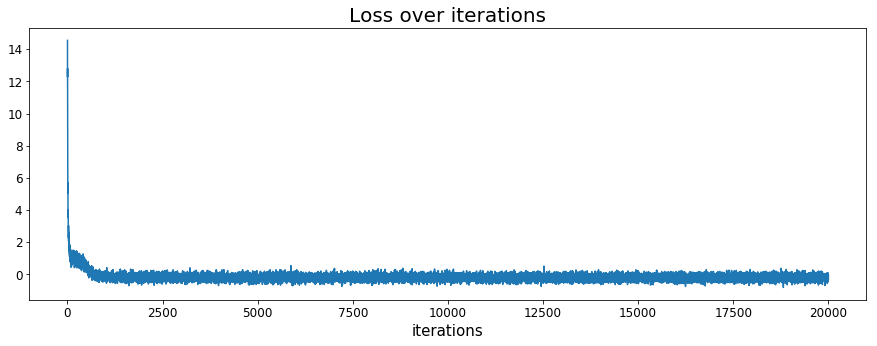

In [64]:
plt.plot(loss)
plt.title('Loss over iterations')
plt.xlabel('iterations')

In [65]:
# generate test data with target parameters 
true_lam = 4.
X_o_poisson = scipy.stats.poisson.rvs(mu=true_lam, size=sample_size)
X_var_poisson = Variable(torch.Tensor(X_o_poisson.astype(float)))

true_p = 0.7
X_o_nb = scipy.stats.nbinom.rvs(n=3., p=true_p, size=sample_size)

In [66]:
# now evaluate the model at the observed data 
stats_o_poisson = calculate_stats(X_o_poisson).astype(float).reshape(1, 1)
stats_o_poisson, norm = normalize(stats_o_poisson, norm)
# add the model identifier 
stats_o_poisson = np.array([[stats_o_poisson[0][0], -1.]])

stats_o_nb = calculate_stats(X_o_nb).astype(float).reshape(1, 1)
stats_o_nb, norm = normalize(stats_o_nb, norm)
# add the model identifier 
stats_o_nb = np.array([[stats_o_nb[0][0], 1.]])

In [67]:
def get_MoG_posterior(model, stats_o, thetas):  
    
    (out_alpha, out_sigma, out_mu) = model(Variable(torch.Tensor(stats_o))) 
    
    # get parameters in torch format
    torch_thetas = Variable(torch.Tensor(thetas)).unsqueeze(1)
    sigmas = out_sigma.expand(n_thetas, n_components)
    mus = out_mu.expand(n_thetas, n_components)
    alphas = out_alpha.expand(n_thetas, n_components)
    
    # get predicted posterior as MoG 
    post = mog_pdf(y=torch_thetas, sigmas=sigmas, mus=mus, alphas=alphas)
    
    return post

In [68]:
n_thetas = 1000
thetas_poisson = np.linspace(0, 15, n_thetas)
thetas_nb = np.linspace(0, 1, n_thetas)
post_poisson = get_MoG_posterior(model, stats_o_poisson, thetas_poisson)
post_nb = get_MoG_posterior(model, stats_o_nb, thetas_nb)

# get true posteriors 
# get analytical gamma posterior 
k = shape + np.sum(X_o_poisson)
theta = 1. / (sample_size + scale)
true_post_poisson = gamma.pdf(x=thetas_poisson, a=k, scale=theta)

# get analytical beta posterior 
a = alp + sample_size * r
b = bet + X_o_nb.sum()
true_post_nb = beta.pdf(thetas_nb, a, b)

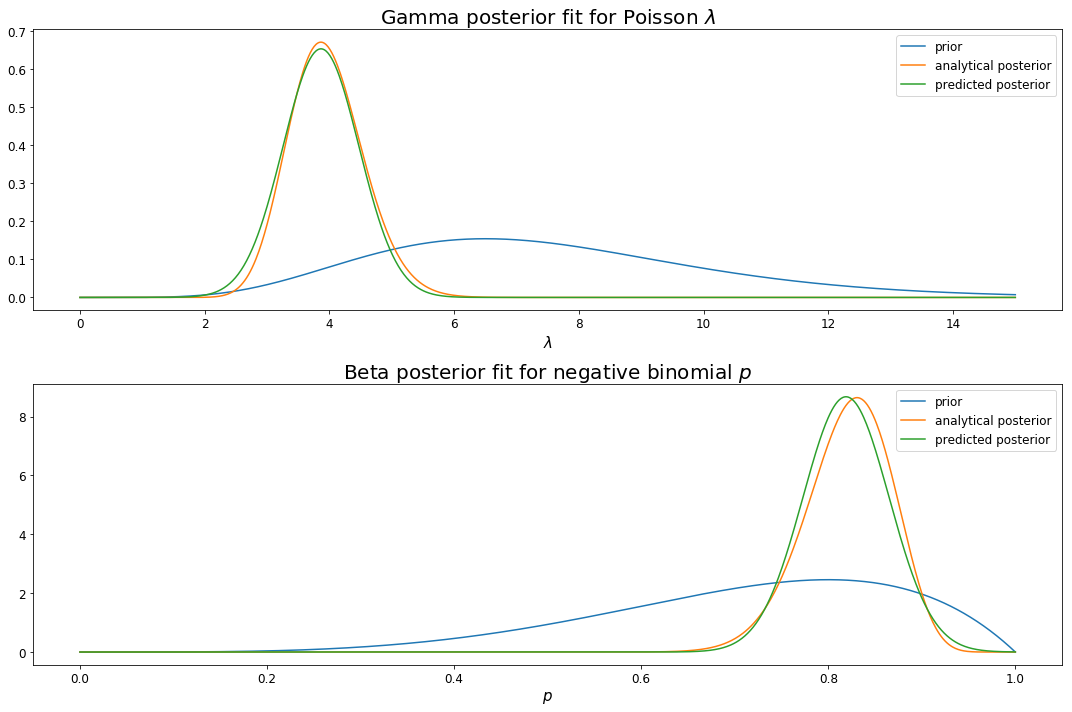

In [73]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title(r'Gamma posterior fit for Poisson $\lambda$')
plt.plot(thetas_poisson, gamma_prior.pdf(thetas_poisson), label='prior')
plt.plot(thetas_poisson, true_post_poisson, label='analytical posterior')
plt.plot(thetas_poisson, post_poisson.data.numpy(), label='predicted posterior')
plt.legend()
plt.xlabel(r'$\lambda$');

plt.subplot(212)
plt.title(r'Beta posterior fit for negative binomial $p$')
thetas = np.linspace(0, 1, n_thetas)
plt.plot(thetas_nb, beta_prior.pdf(thetas), label='prior')
plt.plot(thetas_nb, true_post_nb, label='analytical posterior')
plt.plot(thetas_nb, post_nb.data.numpy(), label='predicted posterior')
plt.legend()
plt.xlabel(r'$p$')
plt.tight_layout()
plt.savefig('figures/universal_mdn_results.png', dpi=300);